In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

In [26]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [33]:
def make_bishop_data(num=1000):
    y = np.linspace(0, 1, num=num)
    x = y + 0.3 * np.sin(2 * np.pi * y) + 0.2 * np.random.rand(num) - 0.1
    return x, y
    

X_train, y_train = make_bishop_data(num=10000)
X_test = np.linspace(0, 1, num=100)

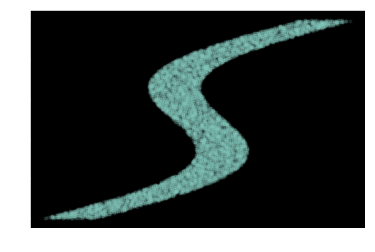

In [5]:
plt.plot(X_train, y_train, '.', alpha=0.1)

# Multi-Quantile Regression

In [22]:
from deepquantiles.multiquantile import MultiQuantileRegressor

In [23]:
regressor = MultiQuantileRegressor(
    shared_units=(8, 8),
    quantile_units=(8, ),
    quantiles=[0.1, 0.3, 0.5, 0.7, 0.9],
    lr=0.001,
    epochs=10,
    batch_size=100
)

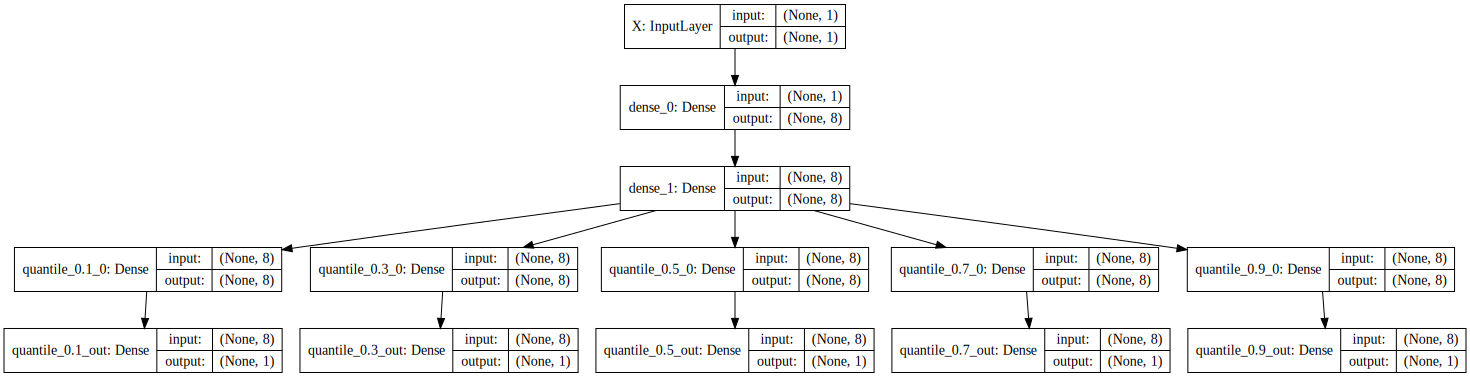

In [24]:
vis_model(regressor.model, show_shapes=True)

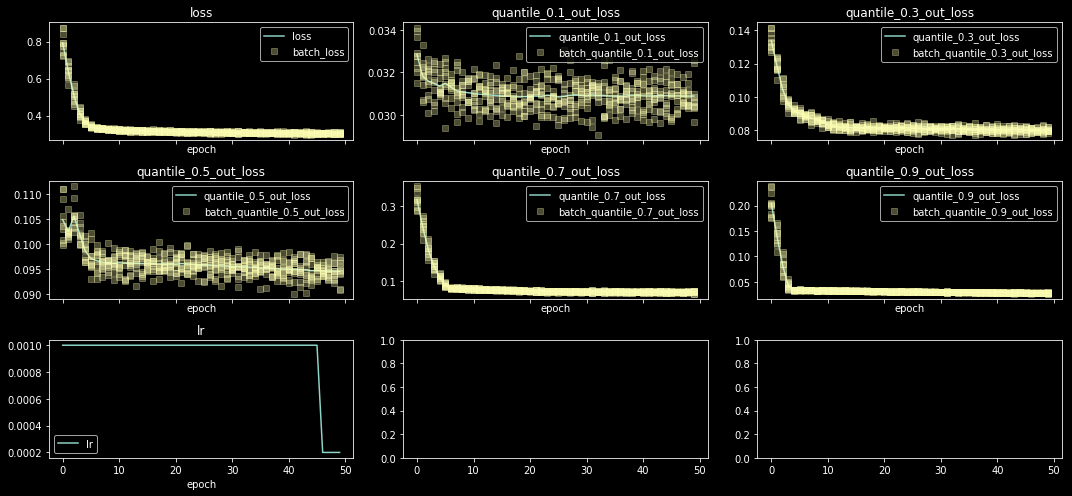

CPU times: user 2min 16s, sys: 16.8 s, total: 2min 33s
Wall time: 1min 13s


In [30]:
%%time
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=True, n_cols=3, figsize=(15, 7))
]

regressor.fit(X_train, y_train, epochs=50, batch_size=1000, verbose=1, callbacks=callbacks)

In [34]:
q_preds = regressor.predict(X_test)

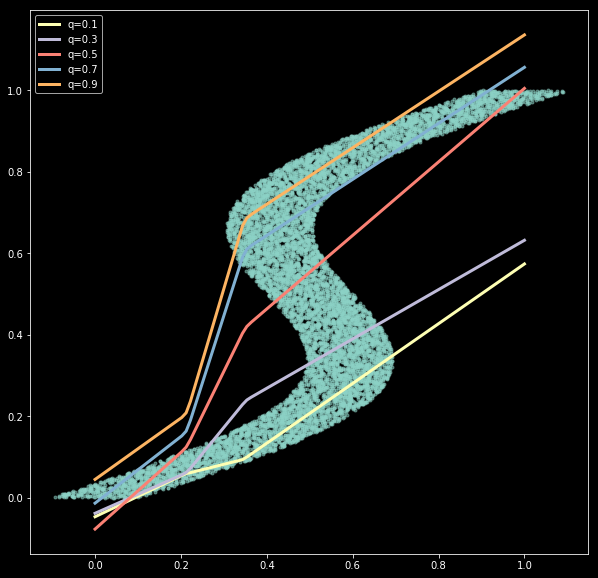

In [37]:
plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, '.', alpha=0.5)
for q, q_pred in zip(regressor.quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'q={q}')
plt.legend()

(0, 1)

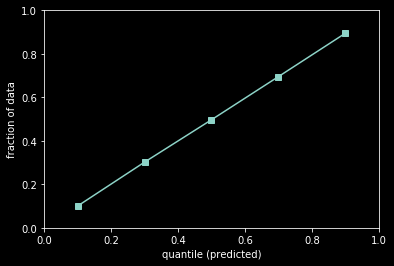

In [39]:
q_preds = regressor.predict(X_train)
calibrations = [np.mean(y_train < q_pred.ravel()) for q, q_pred in zip(regressor.quantiles, q_preds)]
plt.plot(regressor.quantiles, calibrations, 's-')
plt.xlabel('quantile (predicted)')
plt.ylabel('fraction of data')
plt.xlim([0, 1])
plt.ylim([0, 1])

## Regress on Quantile `q`

In [311]:
def tilted_loss_tensor(args):
    q, y_true, y_pred = args
    err = (y_pred - y_true)
    return K.maximum(- q * err, (1 - q) * err)


class SuperQuantileNetwork(MultiNetworkBase):
    
    def _model(
        self,
        *,
        shared_units=(8, 8),
        batch_norm=False,
        lr=0.01
    ):
        input_features = Input(
            (1, ), name='x'
        )
        input_quantile = Input(
            (1, ), name='q'
        )
        input_label = Input(
            (1, ), name='y'
        )
        intermediate = Concatenate()([input_features, input_quantile])
        for idx, units in enumerate(shared_units):
            if batch_norm:
                intermediate = BatchNormalization()(intermediate)
            intermediate = Dense(
                units=units,
                activation='relu',
                name=f'dense_{idx}'
            )(intermediate)
        prediction_output = Dense(1, activation='relu', name='prediction')(intermediate)
        
        
        ##
        quantile_model = Model(
            [input_features, input_quantile], prediction_output, name='Quantile model'
        )
        
        ##
        loss_output = Lambda(tilted_loss_tensor)([input_quantile, input_label, prediction_output])
        
        loss_model = Model(
            [input_features, input_quantile, input_label], loss_output, name='Loss model'
        )

        loss_model.compile(
            optimizer=Adam(lr=lr),
            loss='mean_absolute_error'
        )
        
        
        return {
            'loss': loss_model,
            'quantile': quantile_model
        }

In [319]:
multipipeline = MultiPipeline({
    'x': PandasValueSelector('x'),
    'y': PandasValueSelector('y'),
    'q': PandasValueSelector('q'),
    'zero': PandasValueSelector('zero'),
})

multimodel = MultiModel(
    multinetwork=SuperQuantileNetwork(
        shared_units=(32, 32, 32, 32),
        lr=0.01
    ),
    multipipeline=multipipeline,
    manifold={
        'quantile': [('x', 'q'), None],
        'loss': [('x', 'q', 'y'), 'zero'],
    }
)

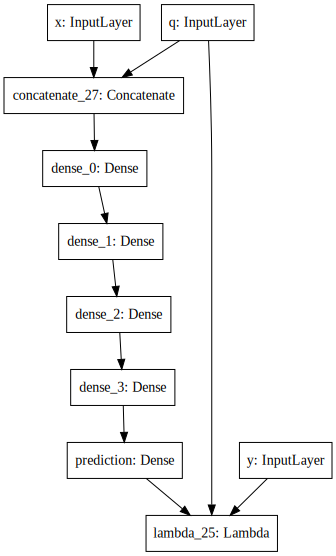

In [320]:
SVG(model_to_dot(multimodel.multinetwork.model['loss'], show_shapes=False).create(prog='dot', format='svg'))

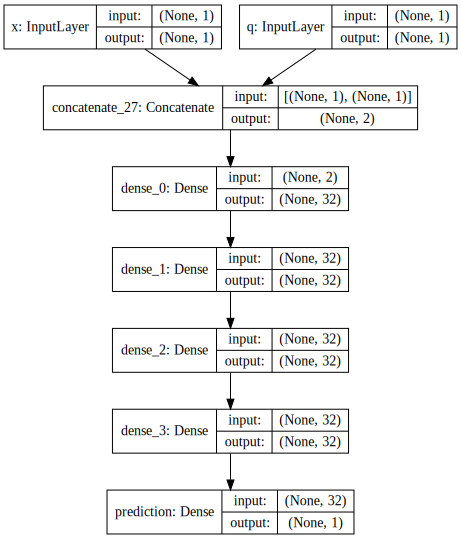

In [321]:
SVG(model_to_dot(multimodel.multinetwork.model['quantile'], show_shapes=True).create(prog='dot', format='svg'))

In [322]:
df_train['zero'] = 0
df_train['q'] = np.random.rand(len(df_train))
df_train.head(3)

,x,y,zero,q
21,-0.091099,0.0021,0,0.423707
18,-0.087304,0.0018,0,0.292553
10,-0.086130,0.0010,0,0.008124


In [323]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=30),
    PlotHistory(batches=True, n_cols=3, figsize=(15, 7))
]

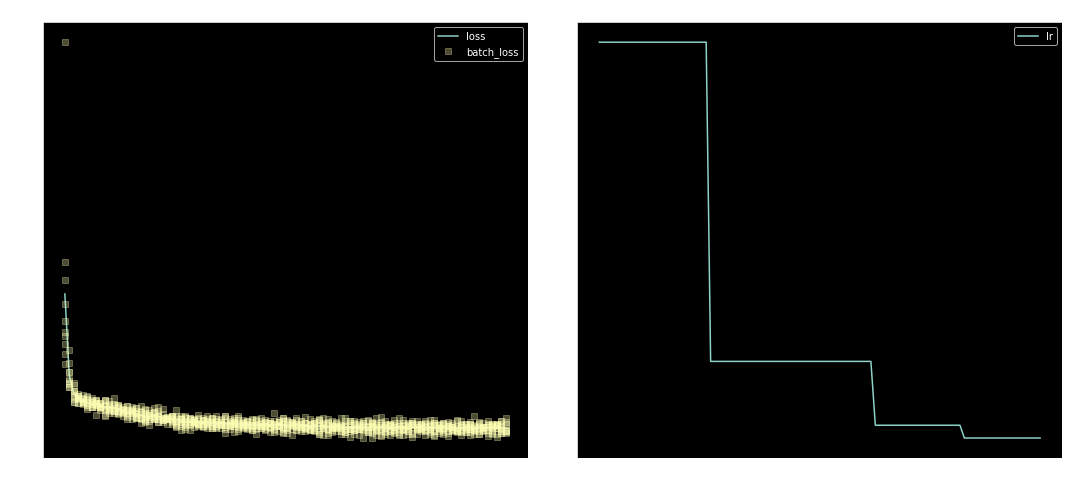

CPU times: user 1min 57s, sys: 14.7 s, total: 2min 11s
Wall time: 60 s


In [324]:
%%time
multimodel.fit(df_train, model='loss', epochs=100, batch_size=1000, verbose=1, callbacks=callbacks)

In [325]:
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
q_preds = []
for q in quantiles:
    df_test['q'] = q
    q_pred = multimodel.predict(df_test, model='quantile')
    q_preds.append(q_pred)

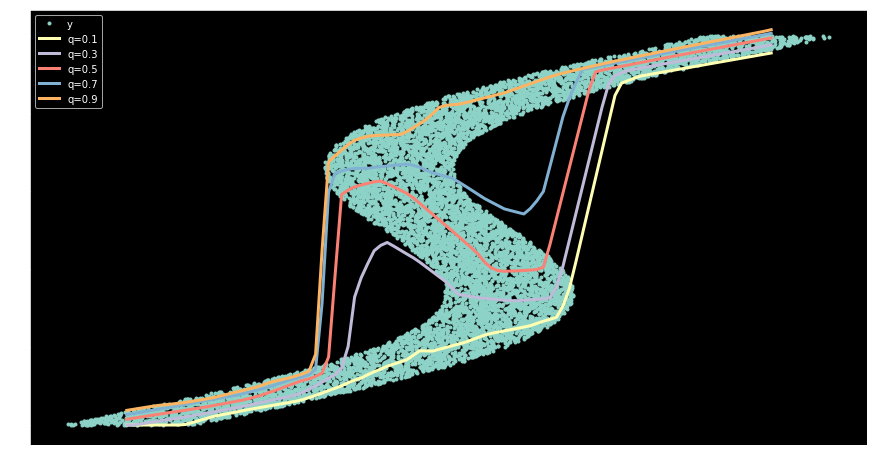

In [326]:
plt.figure(figsize=(15,8))
plt.plot(df_train.x, df_train.y, '.')
for q, q_pred in zip(quantiles, q_preds):
    plt.plot(df_test.x, q_pred, lw=3, label=f'q={q}')
plt.legend()

In [327]:
dfq = pd.DataFrame(data={
    'x': 0.6,
    'q': np.linspace(0, 1, num=50)
})

In [328]:
q_pred = multimodel.predict(dfq, model='quantile')
pdf = np.diff(dfq.q) / np.diff(q_pred.ravel())

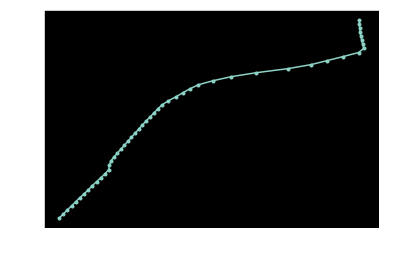

In [329]:
plt.plot(q_pred.ravel(), dfq.q, '.-')
plt.xlabel('y')
plt.ylabel('P(y)');

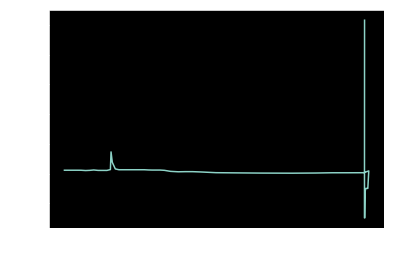

In [330]:
plt.plot(q_pred.ravel()[1:], pdf)
plt.xlabel('y')
plt.ylabel('p(y)');

In [336]:
def sample(x, num_samples=10, num_qs=5):
    P = np.linspace(0, 1, num=num_qs)
    dfq = pd.DataFrame(data={
        'x': x,
        'q': P
    })
    q = multimodel.predict(dfq, model='quantile').ravel()
    uniform = np.random.rand(num_samples)
    samples = np.interp(uniform, P, q)
    return samples

In [337]:
%%time
x = np.linspace(0, 1, num=100)
samples = np.stack([sample(_x, num_samples=1000, num_qs=10) for _x in x])

CPU times: user 335 ms, sys: 15.5 ms, total: 351 ms
Wall time: 326 ms


In [338]:
pred_x = np.hstack([df_test['x'].values.reshape(-1, 1) for _ in range(num_samples)])

In [339]:
pred_x.shape, samples.shape

((100, 1000), (100, 1000))

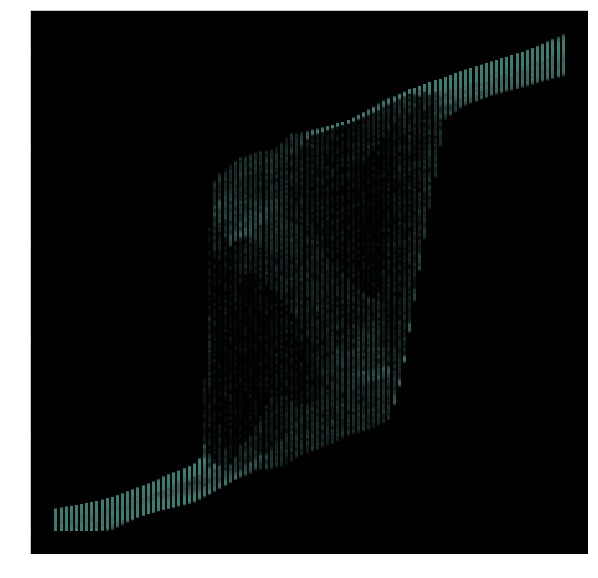

In [342]:
plt.figure(figsize=(10, 10))
plt.plot(pred_x.ravel(), samples.ravel(), '.', alpha=0.01)

In [343]:
means = samples.mean(axis=1)
stds = samples.std(axis=1)
mins = samples.min(axis=1)
maxs = samples.max(axis=1)

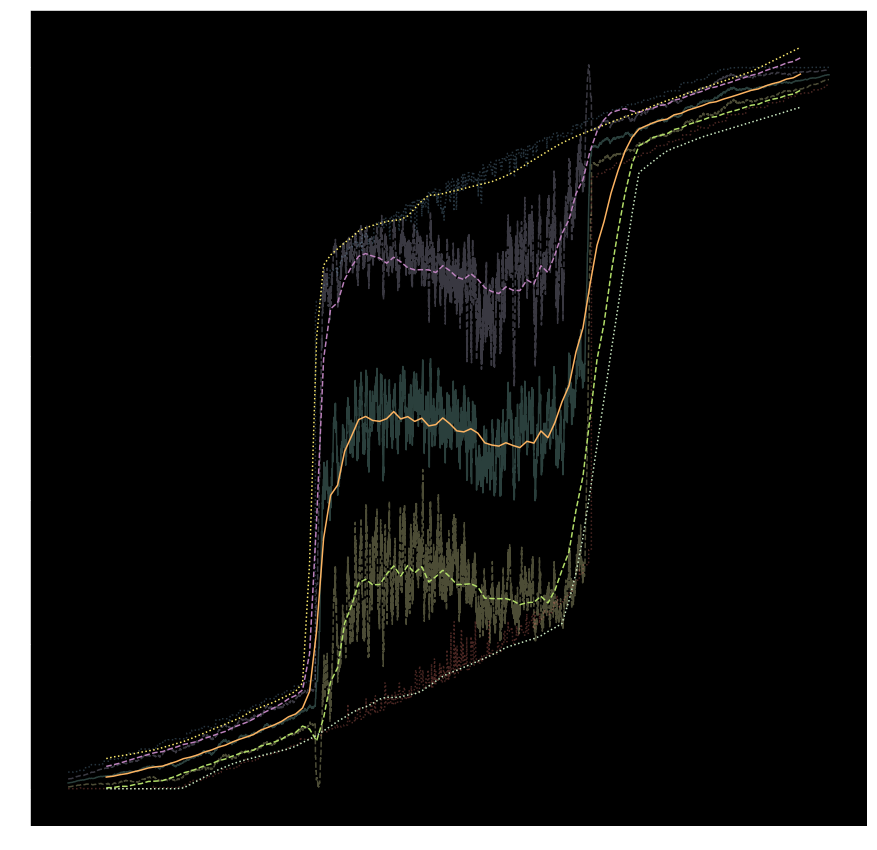

In [344]:
plt.figure(figsize=(15, 15))
window = 50
roll_means = df_train.y.rolling(window=window).mean()
roll_stds = df_train.y.rolling(window=window).std()
roll_maxs = df_train.y.rolling(window=window).max()
roll_mins = df_train.y.rolling(window=window).min()
roll_x = df_train.x.rolling(window=window).mean()
plt.plot(roll_x, roll_means, alpha=0.3)
plt.plot(roll_x, roll_means - roll_stds, '--', alpha=0.3)
plt.plot(roll_x, roll_means + roll_stds, '--', alpha=0.3)
plt.plot(roll_x, roll_mins, ':', alpha=0.3)
plt.plot(roll_x, roll_maxs, ':', alpha=0.3)

plt.plot(x, means)
plt.plot(x, means - stds, '--')
plt.plot(x, means + stds, '--')
plt.plot(x, mins, ':')
plt.plot(x, maxs, ':')